<a href="https://colab.research.google.com/github/LazyTurtleknight/deepl/blob/main/Testing_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Skip this cell if you are not working with colab

!pip install opendatasets
!pip install pandas
!pip install albumentations


In [2]:
import opendatasets as od
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import albumentations as alb
import cv2
import tensorboard
import tensorflow as tf
import datetime
import torch

from torchsummary import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

In [3]:
# Download dataset from kaggle
od.download(
    "https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: simondr
Your Kaggle Key: ··········


100%|██████████| 2.74G/2.74G [00:31<00:00, 92.7MB/s]


In [4]:
# Define constants

# directories
data_dir = 'deepglobe-land-cover-classification-dataset' # change to directory containing the data
train_dir = 'train'
log_dir = 'runs'

In [5]:
# Load metadata and get random sample
metadata = pd.read_csv(os.path.join(data_dir, 'metadata.csv'))

sample = metadata[metadata['split'] == 'train'].sample(n=1)

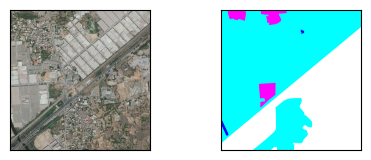

In [6]:
# Plot random sample

def plot(sample):

  plt.figure(figsize=(5,4))
  ax = plt.subplot(2,2,1)
  plt.imshow(np.asarray(Image.open(os.path.join(data_dir, sample['sat_image_path'].iloc[0]))))
  plt.gray()
  ax.get_yaxis().set_visible(False)
  ax.get_xaxis().set_visible(False)

  ax = plt.subplot(2,2,2)
  plt.imshow(np.asarray(Image.open(os.path.join(data_dir, sample['mask_path'].iloc[0]))))
  plt.gray()
  ax.get_yaxis().set_visible(False)
  ax.get_xaxis().set_visible(False)

  plt.show()

plot(sample)

In [7]:
# Test albumentations

sample_path = os.path.join(data_dir, sample['sat_image_path'].iloc[0])
sample_mask_path = os.path.join(data_dir, sample['mask_path'].iloc[0])

# Define augmentation pipeline
transform = alb.Compose([
    alb.RandomCrop(width=128, height=128),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),],
    # we want the mask and the image to have the same augmentation (or at least the same crop)
    # this way we pass the image and the mask simultaneously to the pipeline
    additional_targets={'image': 'image', 'mask': 'mask'}
    )

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread(sample_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_mask = cv2.imread(sample_mask_path)
image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image = image, mask = image_mask)
transformed_image = transformed['image']
transformed_image_mask = transformed['mask']

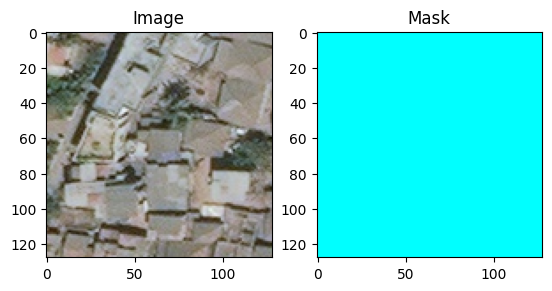

In [8]:
plt.subplot(121),plt.imshow(transformed_image),plt.title('Image');
plt.subplot(122),plt.imshow(transformed_image_mask),plt.title('Mask');

In [44]:
# U-Net

# One block of the encoder. Performs two convolutions and max pooling.
class ConvPool(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.max = nn.MaxPool2d(2, 2)

    def forward(self, x):
        c = self.conv2(self.conv1(x))
        p = self.max(c)
        return c, p

# One block of the decoder. Performs upsampling and two convolutions.
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        self.upsampling = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x, skip):
        u = self.upsampling(x)
        #print(x.shape, u.shape, skip.shape)
        u = torch.cat([u, skip], 0)
        c = self.conv2(self.conv1(u))
        return c, u


class UNet(nn.Module):
    def __init__(self, in_channels, min, max):
        super().__init__()
        self.enc_layers = []
        self.dec_layers = []
        self.enc_final1 = None
        self.enc_final2 = None
        self.dec_final = None

        # List of powers of 2 [16, 32, ..., max]
        channels = []
        power = min
        for i in range(int(np.log2(max // min))):
            channels.append(power)
            power = power*2

        self.enc_layers.append(ConvPool(in_channels, min))
        for i in range(len(channels)-1):
            enc_layer = ConvPool(channels[i], channels[i+1])
            self.enc_layers.append(enc_layer)


        for i in range(len(channels)-1):
            dec_layer = UpConv(channels[i+1], channels[i])
            self.dec_layers.insert(0, dec_layer)
        self.dec_layers.insert(0, UpConv(max, channels[-1]))

        self.enc_layers = nn.ModuleList(self.enc_layers)

        self.dec_layers = nn.ModuleList(self.dec_layers)

        self.enc_final1 = nn.Conv2d(channels[len(channels)-1], max, 3, 1, 'same')
        self.enc_final2 = nn.Conv2d(max, max, 3, 1, 'same')
        self.dec_final = nn.Conv2d(min, 1, 1, 1)

    def forward(self, x):
        skip_connections = []
        p = x
        # Encoder
        for layer in self.enc_layers:
            c, p = layer(p)
            skip_connections.append(c)

        # Bottleneck
        c =  self.enc_final2(self.enc_final1(p))

        # Decoder
        for layer in self.dec_layers:
            skip = skip_connections.pop()
            c, u = layer(c, skip) # if we do not need c we can use _ instead
            print(f'After layer: {c.shape} {u.shape}')

        return self.dec_final(c)






In [10]:
# Set up summary writer for tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(os.path.join(log_dir, current_time))


After layer: torch.Size([128, 16, 16]) torch.Size([256, 16, 16])
After layer: torch.Size([64, 32, 32]) torch.Size([128, 32, 32])
After layer: torch.Size([32, 64, 64]) torch.Size([64, 64, 64])
After layer: torch.Size([16, 128, 128]) torch.Size([32, 128, 128])
torch.Size([1, 128, 128])


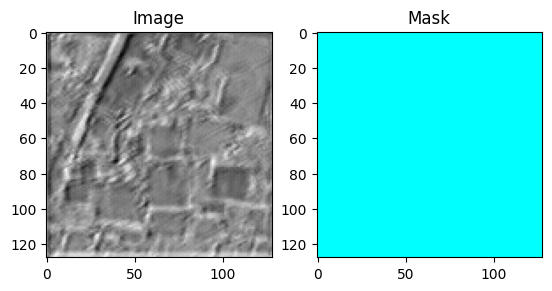

In [48]:
# Training

# configure hyperparameters
epochs = 50

# init data loader/generator
dataloader = None

# init model, optimizer
model = UNet(3, 16, 256)
#print(model)
opt = None
loss_func = None

sample = torch.tensor(transformed_image, dtype=torch.float).T # shape = (3, 256, 256)

model.eval()

pred = model(sample)

print(pred.shape)

pred = pred.T.detach().numpy()

plt.subplot(121),plt.imshow(pred),plt.title('Image');
plt.subplot(122),plt.imshow(transformed_image_mask),plt.title('Mask');

# for epoch in range(epochs):


#     for x, y in dataloader:
#         pred = model(x)
#         loss = loss_func(pred, y)

#         loss.backward()
#         opt.step()
#         opt.zero_grad()
